In [21]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

In [22]:
adata = sc.read_h5ad('./data/h5ab_folder/gse159812_raw_covid_normalized_preprocessed.h5ad')
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [23]:
list_samples = adata.obs['sample'].unique()

In [24]:
list_covid = ['COVID-19_9', 'COVID-19_1', 'COVID-19_11', 'COVID-19_8', 'COVID-19_3',
              'COVID-19_7', 'COVID-19_4', 'COVID-19_12', 'COVID-19_5', 'COVID-19_15',
               'COVID-19_14', 'COVID-19_2', 'COVID-19_6', 'COVID-19_10', 'COVID-19_13']
list_non_covid = ['Control_12', 'Control_2','Control_9', 'Influenza_2', 'Control_10',     
               'Control_13', 'Control_6', 'Control_11', 'Control_8', 'Control_7', 'Influenza_1',
               'Control_5', 'Control_4', 'Control_1', 'Control_3']

for index, row in adata.obs.iterrows():
     if row['sample'] in list_covid:
          new_value = 'covid'
     elif row['sample'] in list_non_covid:
          new_value = 'non_covid'

     adata.obs.at[index, 'covid_non_covid'] = new_value

In [25]:
print('Number of cells of all samples in covid and non covid.')
print(adata.obs['covid_non_covid'].value_counts())
# print('Number of cells of each sample in covid and non covid.')
# adata.obs.groupby('sample')['covid_non_covid'].count()

Number of cells of all samples in covid and non covid.
covid        60039
non_covid    54662
Name: covid_non_covid, dtype: int64


## Sample Classification: Scenario 1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get KDEs of covid and non-covid from UMAP representation (UMAP1~2), and compare them with a new sample cluster’s KDE by KL-divergence.


* Sample for making KDE of covid and non-covid: Sample obtained from `train_test_split` (80% of the total samples)
* Sample to measure how similar to two KDEs: Sample obtained from `train_test_split` (20% of the total samples)


### Hypothesis
There should be similarity between covid samples in KDE, and difference compared to non-covid samples. 

### Get PDE and KDE from UMAP representation in sample making KDE of covid and non-covid

In [26]:
basis_values = adata.obsm['X_umap']

sample_vector = adata.obs['sample'].values
covid_non_covid_vector = adata.obs['covid_non_covid'].values


df_pds = pd.DataFrame(list(zip(basis_values, sample_vector, covid_non_covid_vector)),
               columns =['basis_value', 'sample', 'covid_non_covid'])

In [55]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=7)

print("Samples for making a KDE in existing samples:", y_train) # 24 samples
print("Samples to measure how similar to two KDEs (for a test purpose):", y_test) # 6 samples

Samples for making a KDE in existing samples: ['Control_9', 'COVID-19_10', 'COVID-19_13', 'COVID-19_15', 'COVID-19_8', ..., 'COVID-19_4', 'Control_13', 'COVID-19_11', 'Influenza_1', 'Control_6']
Length: 24
Categories (30, object): ['COVID-19_1', 'COVID-19_2', 'COVID-19_3', 'COVID-19_4', ..., 'Control_12', 'Control_13', 'Influenza_1', 'Influenza_2']
Samples to measure how similar to two KDEs (for a test purpose): ['COVID-19_3', 'Control_8', 'COVID-19_2', 'COVID-19_5', 'COVID-19_7', 'Control_1']
Categories (30, object): ['COVID-19_1', 'COVID-19_2', 'COVID-19_3', 'COVID-19_4', ..., 'Control_12', 'Control_13', 'Influenza_1', 'Influenza_2']


In [56]:
#df_pds['sample'].unique()

Get covid vectors and non-covid vectors from UMAP representation on the train (existing sample) data.

In [57]:
y_train = list(y_train)
y_test = list(y_test)

ext_covid_vector = df_pds.query("sample == @y_train and sample.str.contains('COVID')")['basis_value'].values
ext_non_covid_vector = df_pds.query("sample == @y_train and not sample.str.contains('COVID')")['basis_value'].values

In [58]:
y_train = list(y_train)
y_test = list(y_test)

ext_covid_vector = df_pds.query("sample == @y_train and sample.str.contains('COVID')")['basis_value'].values
ext_non_covid_vector = df_pds.query("sample == @y_train and not sample.str.contains('COVID')")['basis_value'].values

new_covid_vector = []

for v in ext_covid_vector:
    new_covid_vector.append(list(v))

new_non_covid_vector = []

for v in ext_non_covid_vector:
    new_non_covid_vector.append(list(v))

ext_covid_vector = np.array(new_covid_vector)
ext_non_covid_vector = np.array(new_non_covid_vector)

print(f"Number of cells from selected covid samples: {len(ext_covid_vector)}")
print(f"Number of cells from selected non-covid samples: {len(ext_non_covid_vector)}")

Number of cells from selected covid samples: 43045
Number of cells from selected non-covid samples: 48687


In [59]:
x_covid = ext_covid_vector[:, 0]
y_covid = ext_covid_vector[:, 1]
x_n_covid = ext_non_covid_vector[:, 0]
y_n_covid = ext_non_covid_vector[:, 1]

# now determine nice limits by hand:
#binwidth = 0.25
binwidth = 1
xymax = np.max([np.max(np.fabs(x_covid)), np.max(np.fabs(y_covid))])
lim = (int(xymax/binwidth) + 1) * binwidth

kernel_x_covid = stats.gaussian_kde(x_covid)
kernel_y_covid = stats.gaussian_kde(y_covid)
kernel_x_n_covid = stats.gaussian_kde(x_n_covid)
kernel_y_n_covid = stats.gaussian_kde(y_n_covid)
n_sample_covid = np.linspace(-lim+5, lim+5, len(ext_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)
#n_sample_non_covid = np.linspace(-lim+5, lim+5, len(ext_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)

# KDE for UMAP1 (x-axis)
kde_x_covid = kernel_x_covid(n_sample_covid)
kde_x_n_covid = kernel_x_n_covid(n_sample_covid)

# KDE for UMAP2 (y-axis)
kde_y_covid = kernel_y_covid(n_sample_covid)
kde_y_n_covid = kernel_y_n_covid(n_sample_covid)

Text(0.5, 1.0, 'KDE in UMAP2')

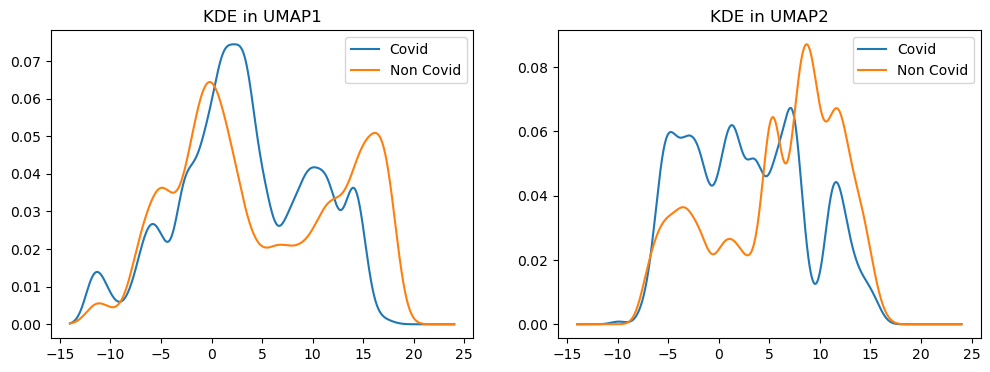

In [60]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# For Covid KDE
ax1.plot(n_sample_covid, kde_x_covid, label='Covid')
ax1.plot(n_sample_covid, kde_x_n_covid, label='Non Covid')
ax1.legend()
ax1.set_title("KDE in UMAP1")

ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
ax2.plot(n_sample_covid, kde_y_n_covid, label='Non Covid')
ax2.legend()
ax2.set_title("KDE in UMAP2")


### Plotting samples to measure how similar to two KDEs (UMAP1 and UMAP2) in test (new) samples

First, getting the vector of test samples from the UMAP representation.

In [61]:
print("Test samples:", y_test)

Test samples: ['COVID-19_3', 'Control_8', 'COVID-19_2', 'COVID-19_5', 'COVID-19_7', 'Control_1']


In [62]:
#df_pds.query("sample == 'COVID-19_13' and sample.str.contains('COVID')")

In [63]:
dict_sample_vec = {} #Key: sample_name, value: basis value as [UMAP1, UMAP2]

for s in y_test:
    dict_sample_vec[s] = np.stack(list(df_pds.query(f"sample == '{s}'")['basis_value'].values[:]))
    print(f"Sample: {s}, size of vecor {len(dict_sample_vec[s])}")

Sample: COVID-19_3, size of vecor 5849
Sample: Control_8, size of vecor 3517
Sample: COVID-19_2, size of vecor 2359
Sample: COVID-19_5, size of vecor 3767
Sample: COVID-19_7, size of vecor 5019
Sample: Control_1, size of vecor 2458


In [64]:
import numpy as np  
from scipy.stats import norm  
from matplotlib import pyplot as plt

#compute KL Divergence
"""KL Divergence(P|Q)"""
def KL_div(p_probs, q_probs):    
    KL_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(KL_div)

result_UMAP1_pred = dict() # Key: sample_name, value: #[Comparison with the exsiting covid sample, Comarison with existing non-covid sample]
result_pred = dict() # Key: sample_name, value: #[Avg of the exsiting covid sample's KL-divergence score between UMAP1 and UMAP2, Avg of the exsiting non-covid sample's KL-divergence score between UMAP1 and UMAP2]

#### A. Compare the existing sample distributions with the test sample distributions based on KL-divergence.

Existing sample: covid, Test sample: COVID-19_3 in UMAP1, KL-divergence: 3413.250035368658
Existing sample: non_covid, Test sample: COVID-19_3 in UMAP1, KL-divergence: 11975.860690531536
Existing sample: covid, Test sample: COVID-19_3 in UMAP2, KL-divergence: 288.95230207492637
Existing sample: non_covid, Test sample: COVID-19_3 in UMAP2, KL-divergence: 574.9156087117382
Existing sample: covid, Test sample: Control_8 in UMAP1, KL-divergence: 2734.210301115397
Existing sample: non_covid, Test sample: Control_8 in UMAP1, KL-divergence: 3083.8599842603876
Existing sample: covid, Test sample: Control_8 in UMAP2, KL-divergence: 2207.892563516824
Existing sample: non_covid, Test sample: Control_8 in UMAP2, KL-divergence: 2210.323718481546
Existing sample: covid, Test sample: COVID-19_2 in UMAP1, KL-divergence: 2695.6765785109587
Existing sample: non_covid, Test sample: COVID-19_2 in UMAP1, KL-divergence: 8579.063831979416
Existing sample: covid, Test sample: COVID-19_2 in UMAP2, KL-divergenc

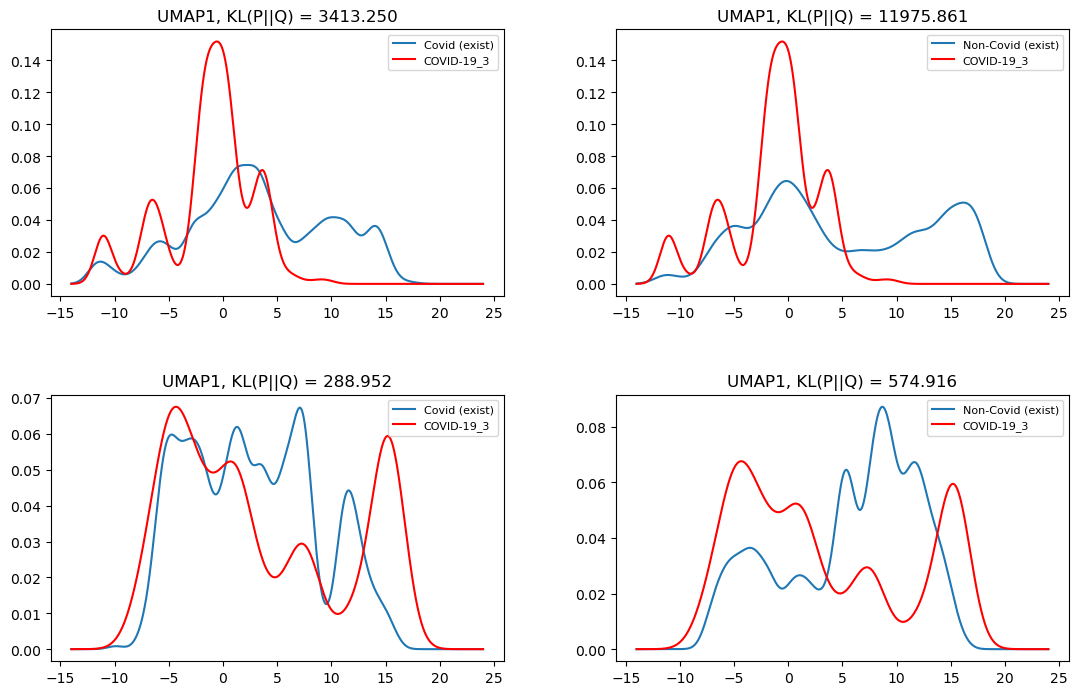

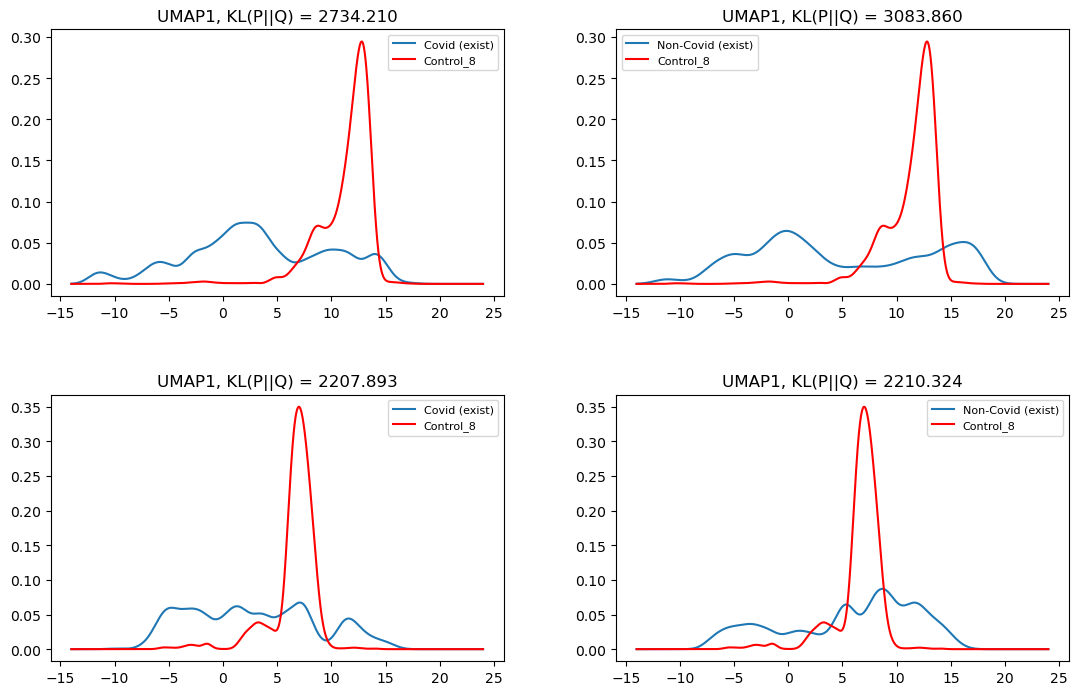

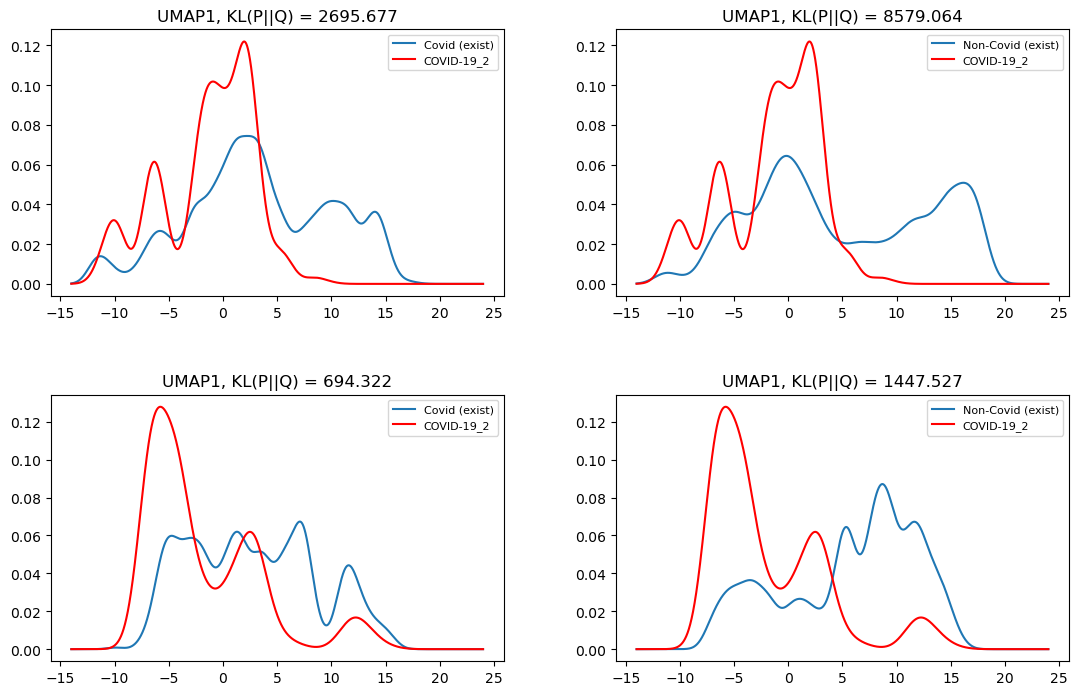

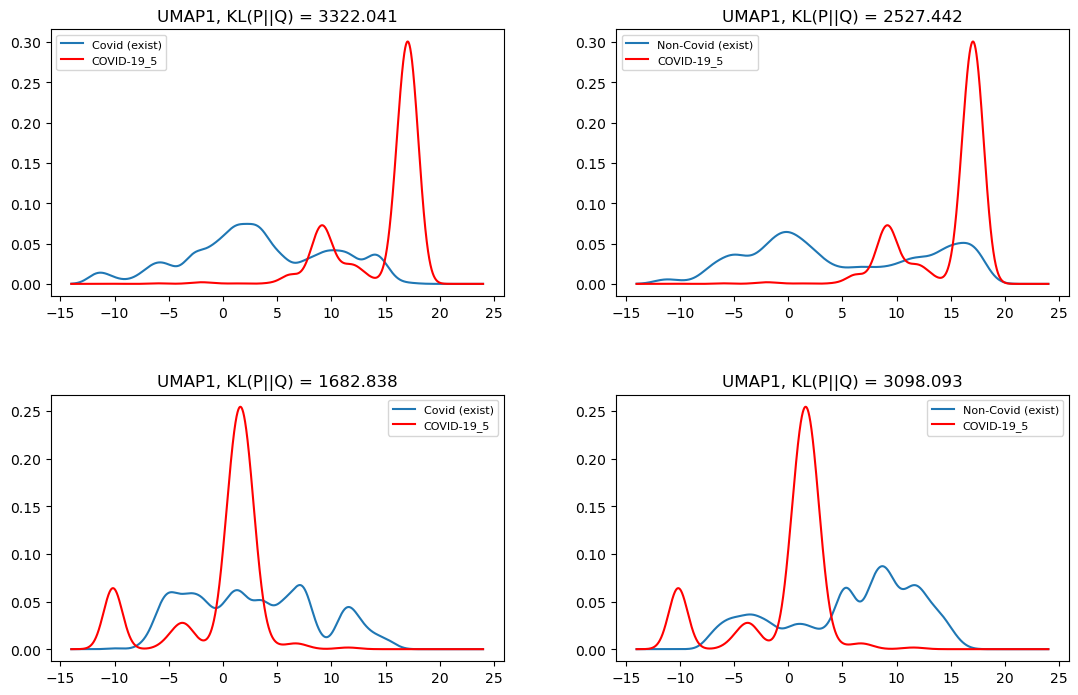

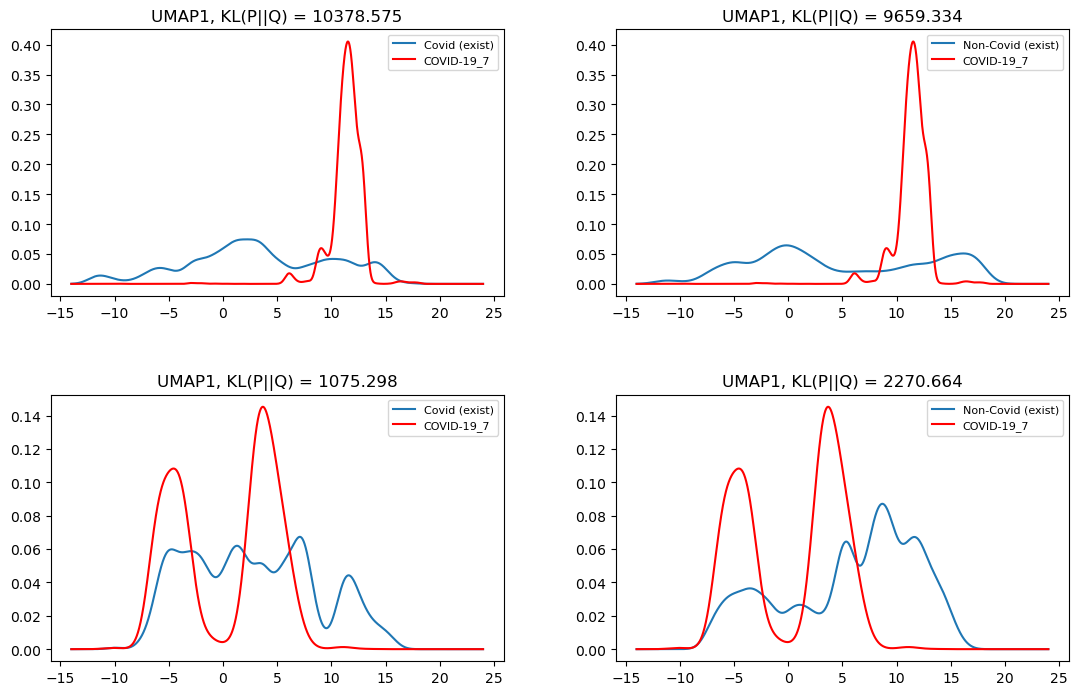

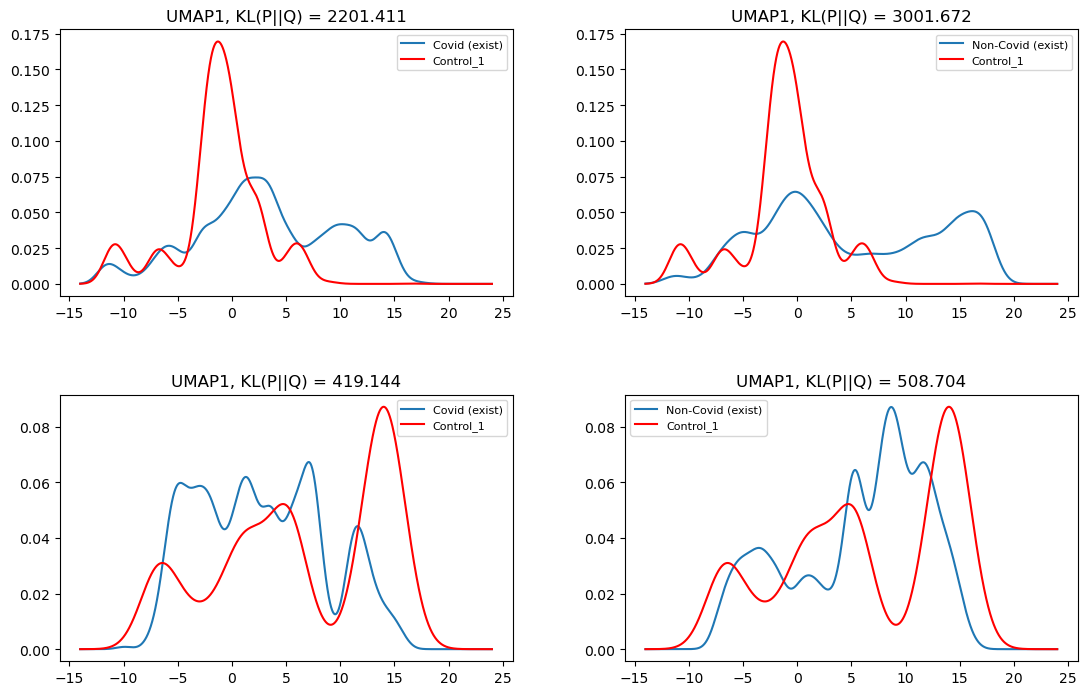

In [65]:
for s, vec in dict_sample_vec.items():
    x_vec = vec[:, 0]
    y_vec = vec[:, 1]

    #Compute kernels of KDE for UMAP1: x-axis and UMAP2: y-axis
    kernel_x = stats.gaussian_kde(x_vec)
    kernel_y = stats.gaussian_kde(y_vec)

    # KDE for UMAP1 (x-axis)
    kde_x_test = kernel_x(n_sample_covid)

    # KDE for UMAP2 (y-axis)
    kde_y_test = kernel_y(n_sample_covid)

    # Get KL-divergence in UMAP 1: x-axis between the existing samples and test sample
    x_KL_d_exis_covid = KL_div(kde_x_covid, kde_x_test)
    x_KL_d_exis_non_covid = KL_div(kde_x_n_covid, kde_x_test)
    # Get KL-divergence in UMAP 2: y-axis between the existing samples and test sample
    y_KL_d_exis_covid = KL_div(kde_y_covid, kde_y_test)
    y_KL_d_exis_non_covid = KL_div(kde_y_n_covid, kde_y_test)

    ### Plot distributions of the existing and test.
    # Initialise the subplot function using number of rows and columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    print(f"Existing sample: covid, Test sample: {s} in UMAP1, KL-divergence: {x_KL_d_exis_covid}")
    axes[0,0].set_title('UMAP1, KL(P||Q) = %1.3f' % x_KL_d_exis_covid)  
    axes[0,0].plot(n_sample_covid, kde_x_covid, label='Covid (exist)')  
    axes[0,0].plot(n_sample_covid, kde_x_test, label=f'{s}', color='red')
    axes[0,0].legend(prop={'size': 8})
    print(f"Existing sample: non_covid, Test sample: {s} in UMAP1, KL-divergence: {x_KL_d_exis_non_covid}")
    axes[0,1].set_title('UMAP1, KL(P||Q) = %1.3f' % x_KL_d_exis_non_covid)  
    axes[0,1].plot(n_sample_covid, kde_x_n_covid, label='Non-Covid (exist)')  
    axes[0,1].plot(n_sample_covid, kde_x_test, label=f'{s}', color='red')
    axes[0,1].legend(prop={'size': 8})

    #result_UMAP1_pred[s] = [x_KL_d_exis_covid, x_KL_d_exis_non_covid]

    print(f"Existing sample: covid, Test sample: {s} in UMAP2, KL-divergence: {y_KL_d_exis_covid}")
    axes[1,0].set_title('UMAP1, KL(P||Q) = %1.3f' % y_KL_d_exis_covid)  
    axes[1,0].plot(n_sample_covid, kde_y_covid, label='Covid (exist)')  
    axes[1,0].plot(n_sample_covid, kde_y_test, label=f'{s}', color='red')
    axes[1,0].legend(prop={'size': 8})
    print(f"Existing sample: non_covid, Test sample: {s} in UMAP2, KL-divergence: {y_KL_d_exis_non_covid}")
    axes[1,1].set_title('UMAP1, KL(P||Q) = %1.3f' % y_KL_d_exis_non_covid)  
    axes[1,1].plot(n_sample_covid, kde_y_n_covid, label='Non-Covid (exist)')  
    axes[1,1].plot(n_sample_covid, kde_y_test, label=f'{s}', color='red')
    axes[1,1].legend(prop={'size': 8})

    # To produce a final prediction score, we sum up the KL-divergence score 
    # between UMAP1 and UMAP2, and then divide by 2 to get an average of UMAP1 and UMAP2.
    result_pred[s] = [(x_KL_d_exis_covid+y_KL_d_exis_covid)/2, (x_KL_d_exis_non_covid+y_KL_d_exis_non_covid)/2]

print("--------Done computing KL-divergence with new samples--------")
print("result_pred:", result_pred)

In [66]:
result_pred

{'COVID-19_3': [1851.101168721792, 6275.388149621637],
 'Control_8': [2471.0514323161105, 2647.0918513709667],
 'COVID-19_2': [1694.999359088647, 5013.295379502236],
 'COVID-19_5': [2502.4396236212265, 2812.7675407990027],
 'COVID-19_7': [5726.936739187298, 5964.999332791541],
 'Control_1': [1310.2775651342363, 1755.1877529166268]}

Pick up the index which has the minimum value from each result.

-> If the KL divergence between two distributions is zero, then it indicates that the distributions are identical. Thus, the smaller value is better.

In [67]:
y_true = [] #0: covid, 1:non-covid
y_pred = []

# Calculate avg of kl-divergence in the covid test sample
for key, value in result_pred.items():
    if 'COVID' in key:
        y_true.append(0)
        y_pred.append(np.argmin(value))
    else:
        y_true.append(1)
        y_pred.append(np.argmin(value))

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


print("Accuracy =", accuracy_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred, average='macro'))
print("Recall = ", recall_score(y_true, y_pred, average='macro'))
print("f1 score = ", f1_score(y_true, y_pred, average='macro'))

Accuracy = 0.6666666666666666
Precision =  0.3333333333333333
Recall =  0.5
f1 score =  0.4


/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
